In [1]:
from config import *

In [ ]:
import torch
from pathlib import Path
import pandas as pd
import wandb
import numpy as np
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from src.style import c_muted


In [ ]:
project = 'iris-grok-distill-mlp'
df = load_result_table(f'{project}/iris-grok-distill-mlp')#, samples=4000)

  0%|          | 0/252 [00:00<?, ?it/s]

In [4]:
df_orig = df.copy()

# Plot the training loss curves of the original teachers

In [5]:
a = df[df.transfer_train_fraction.isna()]
a = a[a.state == 'finished']
print(a.num_epochs.unique())
original_df = a[['name','num_epochs','test_accuracy']]#.set_index('name')

[ 5000 10000 20000]


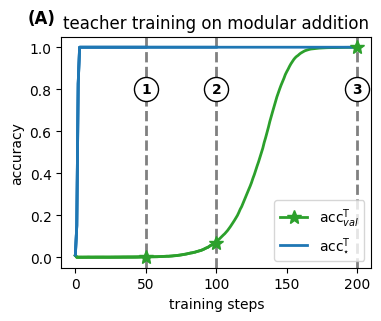

In [6]:
fig, ax = plt.subplots(1, 1, figsize=(4, 3))


for i,num_epochs in enumerate(sorted(a.num_epochs.unique())):
        
        b = a[a.num_epochs == num_epochs]
        run_data = b.iloc[1]
        run = api.run(f"{project}/{run_data.run_id}")
        history = run.history()  

        test_acc = history["test_accuracy"].dropna()
        train_acc = history["train_accuracy"].dropna()
        
        x, y = len(test_acc)-1, 0.8
        ax.scatter(x, y, s=300, facecolors='white', edgecolors='black', zorder=5)
        ax.text(x, y, i+1, ha='center', va='center', color='black', fontsize=10, weight='bold', zorder=6)
        ax.axvline(x, color='grey', lw=2, ls='--',zorder=-10)
        
        ax.plot(test_acc.values, color=metric_styles['teacher_val_acc']['color'], lw=2 )
        ax.plot(train_acc.values, color=metric_styles['teacher_train_acc']['color'], lw=2)
        ax.plot(len(test_acc)-1, test_acc.values[-1], marker='*', color=metric_styles['teacher_val_acc']['color'], markersize=10)
        ax.plot(len(train_acc)-1, train_acc.values[-1], color=metric_styles['teacher_train_acc']['color'], markersize=10)
        
        
ax.plot([],[], marker='*', color=metric_styles['teacher_val_acc']['color'], markersize=10,label=metric_styles['teacher_val_acc']['label'],lw=2)
ax.plot([],[], color=metric_styles['teacher_train_acc']['color'], markersize=10,label=metric_styles['teacher_train_acc']['label'],lw=2)
ax.legend()
ax.set_xlabel('training steps')
ax.set_ylabel('accuracy')
ax.set_title('teacher training on modular addition')
ax.text(-0.02, 1.12 , f'(A)', transform=ax.transAxes, fontsize=12, va='top', ha='right',fontweight='bold')
plt.savefig(FIGURE_DIR / f'{project.split("/")[-1]}-teacher_training_modular_addition.pdf', bbox_inches='tight')

# Plot the student accruacies as a funtion of rho for every temperature

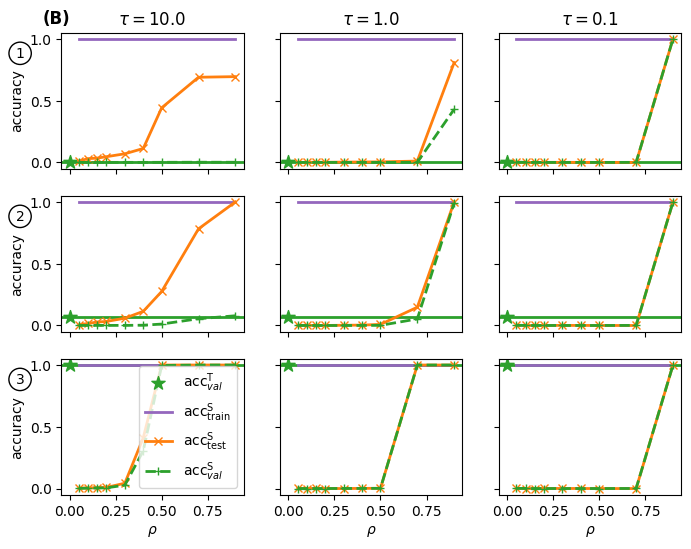

In [7]:
a = df[df.state == 'finished']
a = a[~a.transfer_train_fraction.isna()]
# sort in decending temperature
fig, axes = plt.subplots(3,3, figsize=(8, 6), sharex=True, sharey=True)
for row_idx, num_epochs in enumerate(original_df['num_epochs'].unique()):
    
    for col_idx, (temp, g) in enumerate(a.groupby('transfer_learning_temp')):
        
        ax = axes[row_idx, 2-col_idx]
        if row_idx == 0:
            ax.set_title(r"$\tau="+f"{temp}$")
        
        
        g = g[g.transfer_learning_from.isin(original_df[original_df['num_epochs'] == num_epochs].name.values)]
        
        test_acc = g.groupby('transfer_train_fraction')['test_accuracy'].mean()
        train_acc = g.groupby('transfer_train_fraction')['train_accuracy'].mean()
        mem_acc = g.groupby('transfer_train_fraction')['mem_test_accuracy'].mean()
        teacher_val = original_df[original_df['num_epochs'] == num_epochs].test_accuracy.mean()
        
        ax.axhline(teacher_val, color=metric_styles['teacher_val_acc']['color'],lw=2)
        # Desired data coordinate
        ax.scatter([0],[teacher_val], color=metric_styles['teacher_val_acc']['color'], marker='*', s=100,label=metric_styles['teacher_val_acc']['label'])
        ax.plot(train_acc.index, train_acc.values,  color=metric_styles['student_train_acc']['color'], label=metric_styles['student_train_acc']['label'],lw=2)
        ax.plot(mem_acc.index, mem_acc.values, color=metric_styles['student_test_acc']['color'],label=metric_styles['student_test_acc']['label'],marker='x',lw=2)
        ax.plot(test_acc.index, test_acc.values, color=metric_styles['student_val_acc']['color'], label=metric_styles['student_val_acc']['label'],linestyle='--',marker='+',lw=2)

        
for ax in axes[-1]:
    ax.set_xlabel(r"$\rho$")
for i, ax in enumerate(axes[:,0]):
    ax.set_ylabel("accuracy")
    ax.text(
    -0.25, 0.9,  # near top-left corner
    i+1,
    ha='left',
    va='top',
    fontsize=10,
    color='black',
    transform=ax.transAxes,
    bbox=dict(facecolor='white', edgecolor='black', boxstyle='circle,pad=0.3')
)
    
axes[-1,0].legend()
axes[0,0].text(0.05, 1.17 , f'(B)', transform=axes[0,0].transAxes, fontsize=12, va='top', ha='right',fontweight='bold')
plt.savefig(FIGURE_DIR / f'{project.split("/")[-1]}-student_training_modular_addition.pdf', bbox_inches='tight')
plt.show()

In [8]:
a = df[df.state == 'finished']
a = a[~a.transfer_train_fraction.isna()]
a = a[a.transfer_train_fraction==0.1][a.transfer_learning_temp==10.0][a.transfer_learning_from=='wobbly-jazz-87']

/tmp/ipykernel_3536827/468382477.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  a = a[a.transfer_train_fraction==0.1][a.transfer_learning_temp==10.0][a.transfer_learning_from=='wobbly-jazz-87']
/tmp/ipykernel_3536827/468382477.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  a = a[a.transfer_train_fraction==0.1][a.transfer_learning_temp==10.0][a.transfer_learning_from=='wobbly-jazz-87']


In [9]:
a

,_runtime,_step,_timestamp,_wandb,epoch,model,test_accuracy,test_loss,train_accuracy,train_loss,...,transfer_learning_temp,transfer_train_fraction,random_shift_label_by_pm12,name,entity,project,state,run_id,mem_test_accuracy,mem_test_loss


[ 5000 10000 20000]


/tmp/ipykernel_3536827/1883909932.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  a = a[a.transfer_train_fraction==0.5][a.transfer_learning_temp==10.0]
/tmp/ipykernel_3536827/1883909932.py:33: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  a = a[a.transfer_train_fraction==0.9][a.transfer_learning_temp==0.1]


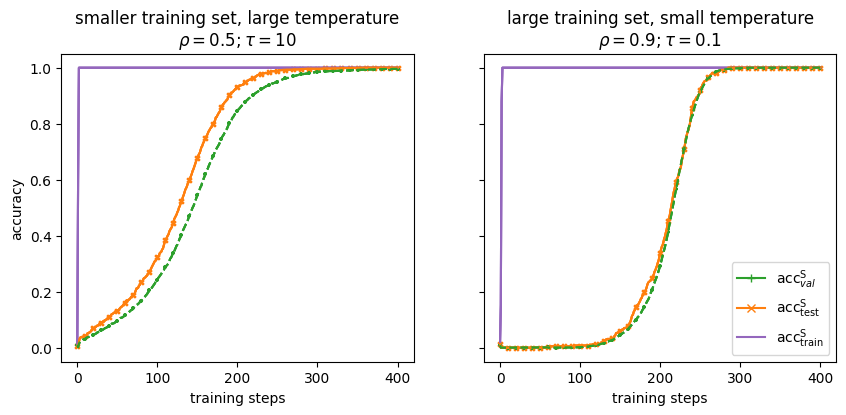

In [ ]:
num_epochs = 20000


fig, axes = plt.subplots(1, 2, figsize=(10, 4),sharex=True, sharey=True)

a = df[df.state == 'finished']
a = a[~a.transfer_train_fraction.isna()]
a = a[a.transfer_learning_from.isin(original_df[original_df['num_epochs'] == num_epochs].name.values)]
a = a[a.transfer_train_fraction==0.5][a.transfer_learning_temp==10.0]

ax = axes[0]
ax.set_title( "smaller training set, large temperature\n" + r"$\rho=0.5; \tau=10$")
for i in range(len(a)):
        run_data = a.iloc[i]
        run = api.run(f"{project}/{run_data.run_id}")
        history = run.history()  

        test_acc = history["test_accuracy"].dropna()
        train_acc = history["train_accuracy"].dropna()
        teacher_test_acc = history['mem_test_accuracy'].dropna()
        
        ax.plot(train_acc.values, color=metric_styles['student_train_acc']['color'])
        ax.plot(teacher_test_acc.values, color=metric_styles['student_test_acc']['color'])
        # put markers every 5th entry
        ax.scatter(np.arange(0, len(train_acc), 10), teacher_test_acc.values[::10], color=metric_styles['student_test_acc']['color'], marker='x', s=10)
        ax.plot(test_acc.values, color=metric_styles['student_val_acc']['color'],linestyle='--')
        ax.scatter(np.arange(0, len(test_acc), 10), test_acc.values[::10], color=metric_styles['student_val_acc']['color'], marker='+', s=10)
        
a = df[df.state == 'finished']
a = a[~a.transfer_train_fraction.isna()]
a = a[a.transfer_learning_from.isin(original_df[original_df['num_epochs'] == num_epochs].name.values)]
a = a[a.transfer_train_fraction==0.9][a.transfer_learning_temp==0.1]
ax = axes[1]
ax.set_title( "large training set, small temperature\n" + r"$\rho=0.9; \tau=0.1$")
for i in range(len(a)):
        run_data = a.iloc[i]
        run = api.run(f"{project}/{run_data.run_id}")
        history = run.history()  

        test_acc = history["test_accuracy"].dropna()
        train_acc = history["train_accuracy"].dropna()
        teacher_test_acc = history['mem_test_accuracy'].dropna()
        
        ax.plot(train_acc.values, color=metric_styles['student_train_acc']['color'])
        ax.plot(teacher_test_acc.values, color=metric_styles['student_test_acc']['color'])
        # put markers every 5th entry
        ax.scatter(np.arange(0, len(train_acc), 10), teacher_test_acc.values[::10], color=metric_styles['student_test_acc']['color'], marker='x', s=10)
        ax.plot(test_acc.values, color=metric_styles['student_val_acc']['color'],linestyle='--')
        ax.scatter(np.arange(0, len(test_acc), 10), test_acc.values[::10], color=metric_styles['student_val_acc']['color'], marker='+', s=10)   

ax.plot([],[], marker='+', color=metric_styles['student_val_acc']['color'], label=metric_styles['student_val_acc']['label'])
ax.plot([],[], marker='x', color=metric_styles['student_test_acc']['color'], label=metric_styles['student_test_acc']['label'])
ax.plot([],[], color=metric_styles['student_train_acc']['color'], label=metric_styles['student_train_acc']['label'])
ax.legend()
axes[0].set_xlabel('training steps')
axes[1].set_xlabel('training steps')
axes[0].set_ylabel('accuracy')

fig.savefig(FIGURE_DIR / f'{project.split("/")[-1]}-student_generalization_speed.pdf', bbox_inches='tight')